# Part-1: Image Classification with K-NN + Library HOG

## Lab 5: Flower Classification Pipeline

**Dataset:** 102 Category Flower Dataset  
**Features:** HOG (Histogram of Oriented Gradients)  
**Classifier:** K-Nearest Neighbors (K-NN)

### Dataset Information
- **Classes:** 10 flower categories (with 100+ images each, selected from 102 available)
- **Total images:** ~1,700 images (split 80:20 for train/test)
- **Image size:** Variable (resize to 64×64)
- **Source:** Oxford 102 Category Flower Dataset


In [1]:
# Imports (simplified)
import os
import time
import warnings
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

warnings.filterwarnings('ignore')
np.random.seed(42)

print("Libraries ready")


Libraries ready


### Dataset Info

**Dataset Configuration:**
- Using **10 flower categories** (from 102 available)
- Only classes with **100+ images** are selected
- Selecting the top 10 classes by image count
- Each category folder contains all images for that flower type
- Data is **split 80:20** for training and testing using stratified sampling
- Category names are provided in `cat_to_name.json`

---


## 1. Dataset Ingest & Preprocessing


In [13]:
# 1.1 Load Flower dataset (local path) - 80:20 Split
print("Loading Flower dataset...")

# Set your local path to the dataset folder
DATASET_ROOT = r"/Users/michaelnguyen/IdeaProjects/ProjectTwo/Knn-Classifier-Oxford-Flower"
DATASET_PATH = os.path.join(DATASET_ROOT, "dataset")
CAT_TO_NAME_PATH = os.path.join(DATASET_ROOT, "cat_to_name.json")

if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at: {DATASET_PATH}")
if not os.path.exists(CAT_TO_NAME_PATH):
    raise FileNotFoundError(f"Category names file not found at: {CAT_TO_NAME_PATH}")

# Load category names
with open(CAT_TO_NAME_PATH, 'r') as f:
    cat_to_name = json.load(f)

# Loader: loads all images from flat directory structure
def load_flower_dataset(dataset_path, cat_to_name_dict, max_classes=None, min_images=100):
    """
    Load flower dataset from flat directory structure
    
    Args:
        dataset_path: Path to dataset folder (contains numbered category folders 1-102)
        cat_to_name_dict: Dictionary mapping category ID to flower name
        max_classes: Maximum number of classes to load (None = all)
        min_images: Minimum number of images per class (default: 100)
    """
    images, labels = [], []
    
    # Get all category directories with their image counts
    category_info = []
    for d in os.listdir(dataset_path):
        cat_path = os.path.join(dataset_path, d)
        if os.path.isdir(cat_path):
            img_count = len([f for f in os.listdir(cat_path) 
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            if img_count >= min_images:
                category_info.append((d, img_count))
    
    # Sort by image count (descending) to get classes with most data
    category_info.sort(key=lambda x: x[1], reverse=True)
    
    # Limit to max_classes if specified
    if max_classes:
        category_info = category_info[:max_classes]
    
    # Extract just the category directories, sorted by category number
    category_dirs = sorted([cat_dir for cat_dir, _ in category_info], 
                          key=lambda x: int(x))
    
    # Create mapping from category dir to class index
    cat_dir_to_idx = {cat_dir: idx for idx, cat_dir in enumerate(category_dirs)}
    
    # Get class names in order
    class_names = [cat_to_name_dict.get(cat_dir, f"Unknown_{cat_dir}") 
                   for cat_dir in category_dirs]
    
    for cat_dir in category_dirs:
        cat_path = os.path.join(dataset_path, cat_dir)
        class_idx = cat_dir_to_idx[cat_dir]
        
        files = [f for f in os.listdir(cat_path)
                 if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        
        for f in files:
            img_path = os.path.join(cat_path, f)
            try:
                img = imread(img_path)
                if img.ndim == 3:
                    img = rgb2gray(img)
                elif img.ndim == 2:
                    pass  # already grayscale
                else:
                    continue  # skip invalid images
                images.append(img)
                labels.append(class_idx)
            except Exception:
                continue
    
    return np.array(images, dtype=object), np.array(labels), class_names

# Config: Use 10 classes with 100+ images per class
MAX_CLASSES = 10
MIN_IMAGES_PER_CLASS = 100

print(f"Loading dataset (Top {MAX_CLASSES} classes with {MIN_IMAGES_PER_CLASS}+ images)...")
X_all_raw, y_all, class_names = load_flower_dataset(
    DATASET_PATH,
    cat_to_name,
    max_classes=MAX_CLASSES,
    min_images=MIN_IMAGES_PER_CLASS
)

print(f"\nLoaded {len(X_all_raw)} total images")
print(f"Number of flower categories: {len(class_names)}")
print(f"\nSelected flower categories:")
for i, name in enumerate(class_names):
    print(f"  {i+1}. {name}")

# Split dataset into 80% train, 20% test with stratification
print("\nSplitting dataset into 80% train, 20% test...")
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_all_raw, 
    y_all, 
    test_size=0.2, 
    random_state=42,
    stratify=y_all  # Ensures balanced class distribution
)

print(f"Training set: {len(X_train_raw)} images ({len(X_train_raw)/len(X_all_raw)*100:.1f}%)")
print(f"Test set: {len(X_test_raw)} images ({len(X_test_raw)/len(X_all_raw)*100:.1f}%)")


Loading Flower dataset...
Loading dataset (Top 10 classes with 100+ images)...

Loaded 1505 total images
Number of flower categories: 10

Selected flower categories:
  1. wallflower
  2. petunia
  3. water lily
  4. rose
  5. passion flower
  6. lotus lotus
  7. frangipani
  8. cyclamen
  9. watercress
  10. foxglove

Splitting dataset into 80% train, 20% test...
Training set: 1204 images (80.0%)
Test set: 301 images (20.0%)


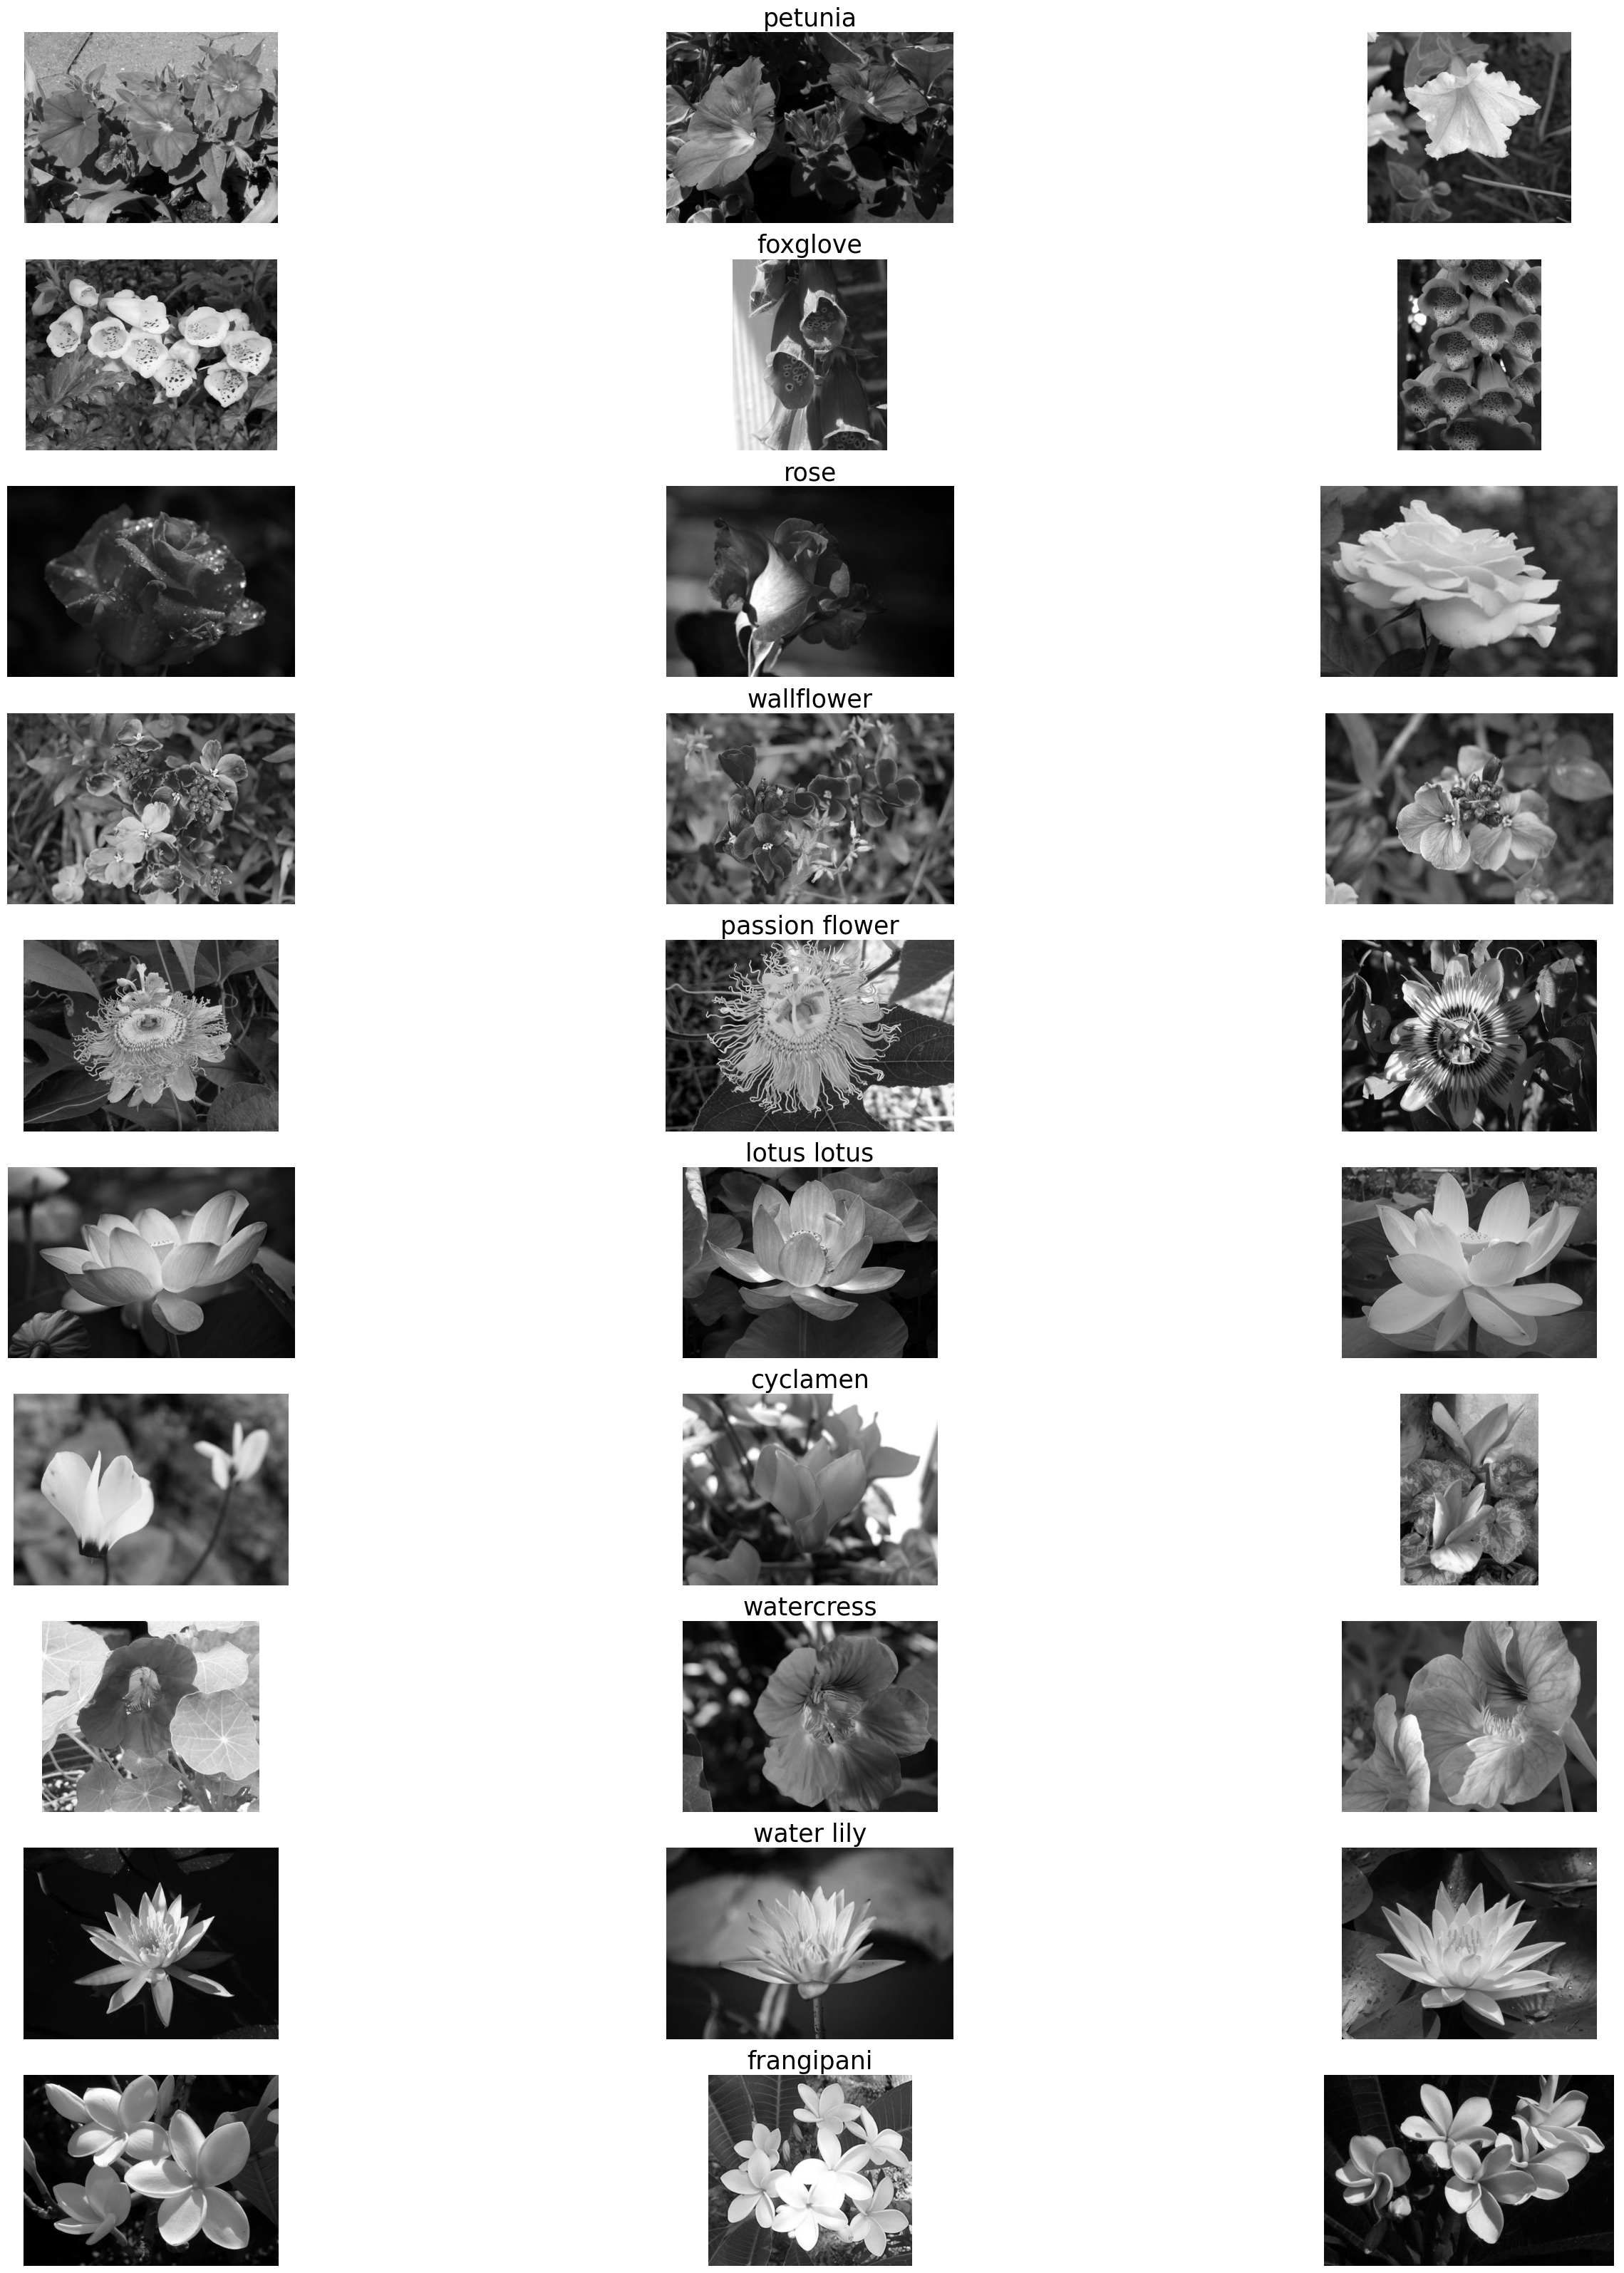

In [14]:
# 1.2 Quick peek at a few images

# Number of classes and samples to display
num_classes_to_show = min(10, len(class_names))  # show up to 5 classes
samples_per_class = 3

# Randomly choose classes
chosen_class_indices = np.random.choice(len(class_names), num_classes_to_show, replace=False)

fig, axes = plt.subplots(num_classes_to_show, samples_per_class, figsize=(32, 32))


for i, class_idx in enumerate(chosen_class_indices):
    # Find all indices belonging to this class
    class_image_indices = np.where(y_train == class_idx)[0]
    
    # Randomly select a few images from this class
    selected_indices = np.random.choice(class_image_indices, samples_per_class, replace=False)
    
    for j, img_idx in enumerate(selected_indices):
        img = X_train_raw[img_idx]
        axes[i, j].imshow(img, cmap="gray")
        axes[i, j].axis("off")
        
        # Add class name as title for the middle image in the row
        if j == 1:
            axes[i, j].set_title(class_names[class_idx], fontsize=25)

plt.tight_layout()
plt.show()



In [15]:
# 1.3 Resize to 64×64 and normalize to [0, 1]
TARGET_SIZE = 64

def preprocess_images(images):
    out = np.empty((len(images), TARGET_SIZE, TARGET_SIZE), dtype=np.float32)
    for i, img in enumerate(images):
        out[i] = resize(img, (TARGET_SIZE, TARGET_SIZE), anti_aliasing=True).astype(np.float32)
    return out

print("Preprocessing training images:")
X_train_resized = preprocess_images(X_train_raw)
print(f"Training set resized: {X_train_resized.shape} | range=({X_train_resized.min():.3f},{X_train_resized.max():.3f})")

print("Preprocessing test images:")
X_test_resized = preprocess_images(X_test_raw)
print(f"Test set resized: {X_test_resized.shape} | range=({X_test_resized.min():.3f},{X_test_resized.max():.3f})")


Preprocessing training images:
Training set resized: (1204, 64, 64) | range=(0.000,1.000)
Preprocessing test images:
Test set resized: (301, 64, 64) | range=(0.000,1.000)


In [16]:
# 1.4 Dataset summary
print(f"Training images: {len(X_train_resized)} | Test images: {len(X_test_resized)}")
print(f"Total images: {len(X_train_resized) + len(X_test_resized)} | Flower categories: {len(class_names)}")


Training images: 1204 | Test images: 301
Total images: 1505 | Flower categories: 10


## 2. HOG Feature Extraction (Library API)


In [17]:
# 2.1 HOG parameters (simple defaults)
HOG_PARAMS = dict(
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=False,
    feature_vector=True,
)
print("HOG params:", HOG_PARAMS)


HOG params: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (2, 2), 'block_norm': 'L2-Hys', 'visualize': False, 'feature_vector': True}


In [18]:
# 2.2 Extract HOG features

def extract_hog_features(images):
    return np.array([hog(img, **HOG_PARAMS) for img in images])

# Note: We're using pre-split train/test data from the dataset
print("Extracting HOG features from training set")
X_train_hog = extract_hog_features(X_train_resized)
print(f"Train features: {X_train_hog.shape}")

print("Extracting HOG features from test set")
X_test_hog = extract_hog_features(X_test_resized)
print(f"Test features: {X_test_hog.shape}")


Extracting HOG features from training set
Train features: (1204, 1764)
Extracting HOG features from test set
Test features: (301, 1764)


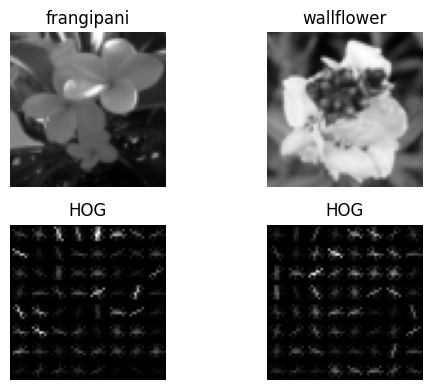

In [19]:
# 2.3 (optional) Quick HOG visualization for 2 samples
sample_indices = [0, 1]
fig, axes = plt.subplots(2, len(sample_indices), figsize=(6,4))
for j, i in enumerate(sample_indices):
    axes[0, j].imshow(X_train_resized[i], cmap='gray')
    axes[0, j].set_title(class_names[y_train[i]][:18])
    axes[0, j].axis('off')
    _, hog_img = hog(X_train_resized[i], visualize=True, **{k:v for k,v in HOG_PARAMS.items() if k!='visualize'})
    axes[1, j].imshow(hog_img, cmap='gray')
    axes[1, j].set_title('HOG')
    axes[1, j].axis('off')
plt.tight_layout()
plt.show()


## 3. K-NN Classifier


### 3.1 K Sweep: Evaluating Different K Values


In [20]:
# 3.1 K sweep (concise)
k_values = [1, 3, 5, 7, 9, 11]
train_accs, test_accs = [], []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_hog, y_train)
    train_accs.append(accuracy_score(y_train, knn.predict(X_train_hog)))
    test_accs.append(accuracy_score(y_test, knn.predict(X_test_hog)))

best_k = k_values[int(np.argmax(test_accs))]
print("Best K:", best_k, " Test Acc:", max(test_accs))


Best K: 1  Test Acc: 0.2425249169435216


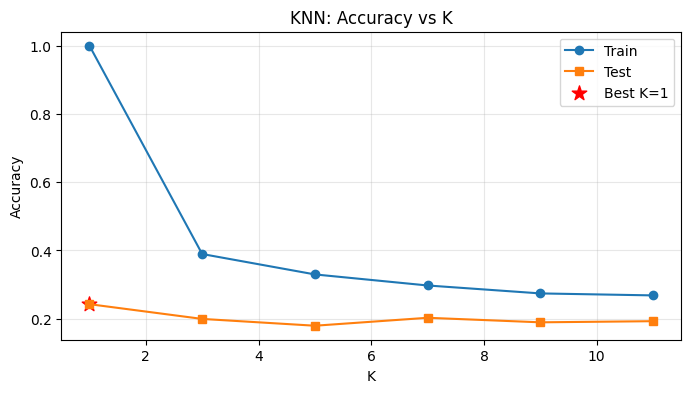

In [21]:
# 3.2 Accuracy vs K (single plot)
plt.figure(figsize=(8,4))
plt.plot(k_values, train_accs, marker='o', label='Train')
plt.plot(k_values, test_accs, marker='s', label='Test')
plt.scatter([best_k], [max(test_accs)], color='red', s=120, marker='*', label=f'Best K={best_k}')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('KNN: Accuracy vs K')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


### Misclassifications


Total misclassified samples: 228


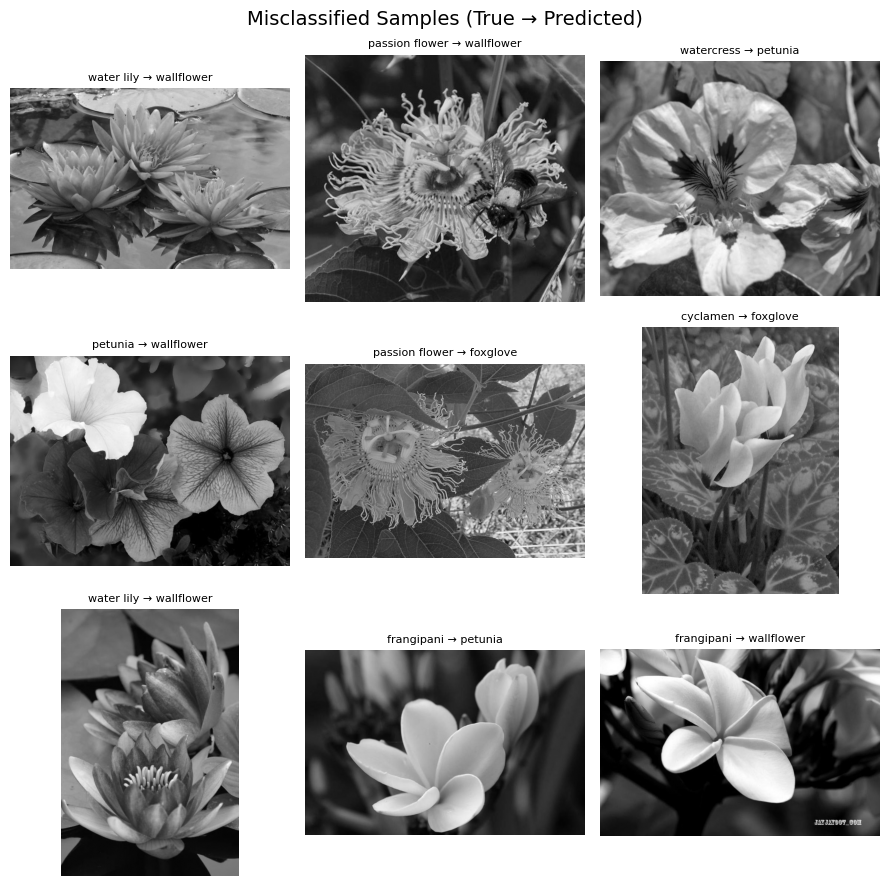

In [22]:
# Misclassifications
from skimage.color import rgb2gray  # already imported above; safe to repeat

mis_idx = np.where(y_test_pred_final != y_test)[0]
print(f"\nTotal misclassified samples: {len(mis_idx)}")

# Shuffle and select up to 9 to display
np.random.shuffle(mis_idx)
num_to_show = min(9, len(mis_idx))
selected_idx = mis_idx[:num_to_show]

rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
fig.suptitle("Misclassified Samples (True → Predicted)", fontsize=14)

# Plot available misclassified samples (up to 9)
for ax, idx in zip(axes.flat, selected_idx):
    img = X_test_raw[idx]
    if img.ndim == 3:
        img = rgb2gray(img)
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_test_pred_final[idx]]
    ax.set_title(f"{true_label} → {pred_label}", fontsize=8)

# Hide any unused subplots if fewer than 9
for ax in axes.flat[num_to_show:]:
    ax.axis("off")

plt.tight_layout()
plt.savefig("misclassified_samples.png", dpi=150, bbox_inches="tight")
plt.show()


### 3.3 Final Model with Best K


In [23]:
# 3.3 Train final model with best K
# reuse best_k from previous step
print(f"Training final K-NN model with best K = {best_k}")

# Train final model
final_knn = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
final_knn.fit(X_train_hog, y_train)

# Final predictions
y_train_pred_final = final_knn.predict(X_train_hog)
y_test_pred_final = final_knn.predict(X_test_hog)

# Calculate final accuracies
final_train_acc = accuracy_score(y_train, y_train_pred_final)
final_test_acc = accuracy_score(y_test, y_test_pred_final)

print(f"Final Model Performance (K = {best_k}):")
print(f"  Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"  Test Accuracy:     {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
print(f"  Accuracy Gap:      {final_train_acc - final_test_acc:.4f}")


Training final K-NN model with best K = 1
Final Model Performance (K = 1):
  Training Accuracy: 1.0000 (100.00%)
  Test Accuracy:     0.2425 (24.25%)
  Accuracy Gap:      0.7575
